In [2]:
# Imports
import cv2
import os
import numpy as np
import pandas as pd
import shutil
import kagglehub
import keras

import tensorflow as tf
from keras.applications import ResNet50V2, MobileNetV2
from keras import layers, models
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.src.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from scipy.ndimage import center_of_mass

# Visualization
import matplotlib.pyplot as plt

## Handtracking and Image modification
from cvzone.HandTrackingModule import HandDetector
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops, block_reduce

C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Projet - Air Drawing
---
## Membres équipe :
BAILLIEN Florian<br>
KINET Antoine<br>
RUYMAEKERS Axel

## 0) Introduction et présentation du projet
Nous avons choisi d’explorer la catégorie « Classification d’Images Avancée » avec une application pratique orientée vers la reconnaissance de caractères dessinés à la main, ce qui s’inscrit dans le cadre du projet "Air Drawing".

Notre démarche a été structurée autour de deux grandes approches complémentaires :
1) Conception et entraînement de réseaux de neurones convolutifs (CNN) "maison", construits de zéro.
2) Utilisation du Transfer Learning avec des modèles pré-entraînés populaires, tels que MobileNetV2 et ResNet50V2, en appliquant les techniques de feature extraction puis de fine-tuning.

Nous avons commencé par rechercher et sélectionner des datasets d’images adaptés, notamment des alphabets manuscrits (A-Z Handwritten Alphabets, EMNIST Letters et EMNIST By_Class), afin de disposer d’un jeu de données pertinent, équilibré et suffisamment riche pour entraîner nos modèles tout en respectant les contraintes techniques du projet.<br>
Ensuite nous avons entrainer chaque modèle et ressortis les graphique d'apprentissage dans le but d'ammener vers une conclusion de quel modèle était le plus performant, afin d'orienter la suite du projet.<br>
Enfin, nous avons validé notre travail par un test réel utilisant des images capturées en conditions concrètes via notre smartphone, afin d’évaluer la capacité du meilleur modèle à généraliser hors du cadre strict des données d’entraînement.


## 1) Datsets
---

### 1.1) A-Z Handwritten Alphabets
Le jeu de données A–Z Handwritten Characters est un ensemble de lettres manuscrites dérivé principalement du NIST Special Database 19 et d'autres sources comme N-MNIST. Il a été converti en images de 28x28 pixels en niveaux de gris, avec chaque lettre majuscule centrée dans un cadre de 20x20 pixels. Ce dataset comprend 26 classes (A à Z) et est destiné à l’entraînement de modèles de reconnaissance de lettres manuscrites. Bien que les images soient bien structurées en dossiers par lettre, le fichier CSV associé ne contient pas explicitement les labels, ce qui nécessite un traitement complémentaire pour l’utiliser directement en apprentissage supervisé.<br>
Nous avons donc chercher un DataSet plus général comprenant encore plus de données, surtout avec un label pour chaque données.

### 1.2) EMNIST
Le jeu de données EMNIST (Extended MNIST) est un ensemble de caractères manuscrits dérivé de la base de données NIST Special Database 19. Il a été converti au format d’image 28x28 pixels, avec une structure de données qui correspond directement à celle du jeu de données MNIST. EMNIST étend MNIST en incluant non seulement des chiffres, mais aussi des lettres majuscules et minuscules manuscrites, offrant ainsi un ensemble plus riche pour les tâches de reconnaissance de caractères.

In [2]:
# Télécharger dans le dossier par défaut non modifiable (cache de kagglehub)
dataset_path = kagglehub.dataset_download("crawford/emnist")

# Dossier cible
custom_path = "./Datasets/emnist_datasets"
os.makedirs(custom_path, exist_ok=True)

# Parcourir tout ce qu’il y a dans dataset_path
for item in os.listdir(dataset_path):
    src = os.path.join(dataset_path, item)
    dst = os.path.join(custom_path, item)
    shutil.move(src, dst)

### 1.2.1) EMNIST (Letters)
Le jeu de données EMNIST Letters fusionne un ensemble équilibré de lettres majuscules et minuscules en une seule tâche de classification à 26 classes (une par lettre de l’alphabet).

- Entraînement : 88 800 images
- Test : 14 800 images
- Total : 103 600 images
- Nombre de classes : 26 (répartition équilibrée)


In [9]:
# Recupération des train_data de EMNIST Letters
def train_data_emnist_letters():
    return pd.read_csv('./Datasets/emnist_datasets/emnist-letters-train.csv', header=None).to_numpy()

# Recupération des test_data de EMNIST Letters
def test_data_emnist_letters():
    return pd.read_csv('./Datasets/emnist_datasets/emnist-letters-test.csv', header=None).to_numpy()

# Recupération des label_mapping de EMNIST Letters
def label_mapping_emnist_letters():
    return np.genfromtxt('./Datasets/emnist_datasets/emnist-letters-mapping.txt', delimiter=' ')

# Taille des fichiers d'entrainement
print(f"train_data_emnist_letters : {train_data_emnist_letters().shape}")
print(f"test_data_emnist_letters : {test_data_emnist_letters().shape}")

train_data_emnist_letters : (88800, 785)
test_data_emnist_letters : (14800, 785)


### 1.2.2) EMNIST (By_Class)
L'ensemble complet de la base de données EMNIST est disponible dans le sous-ensembles ByClass.
Le jeu ByClass contient 62 classes distinctes : les 10 chiffres (0–9), les 26 lettres majuscules (A–Z) et les 26 lettres minuscules (a–z).<br>
La répartition est déséquilibrée : certaines classes ont beaucoup plus d’exemples que d’autres.<br>
La fréquence des lettres reflète à peu près leur fréquence d'usage dans la langue anglaise.

__Taille des ensembles :__
- Entraînement : 697 932 images
- Test : 116 323 images
- Total : 814 255 images

__Classes :__
- ByClass : 62 classes (déséquilibrées)

In [10]:
# Recupération des train_data de EMNIST By_Class
def train_data_emnist_byclass(limit=250000):
    return pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-train.csv', header=None, nrows=limit).to_numpy()

# Recupération des test_data de EMNIST By_Class
def test_data_emnist_byclass():
    return pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-test.csv', header=None).to_numpy()

# Recupération des label_mapping de EMNIST By_Class
def label_mapping_emnist_byclass():
    return np.genfromtxt('./Datasets/emnist_datasets/emnist-byclass-mapping.txt', delimiter=' ')

# Taille des fichiers d'entrainement
print(f"train_data_emnist_byclass : {train_data_emnist_byclass().shape}")
print(f"test_data_emnist_byclass : {test_data_emnist_byclass().shape}")

train_data_emnist_byclass : (250000, 785)
test_data_emnist_byclass : (116323, 785)


Les test_data permet au modèle de voir s'il se généralise bien et qu'il ne fait pas du sur-apprentissage (évaluation époque par époque).
Pratique pour stopper ou débugger l'entrainement du modèle.

W


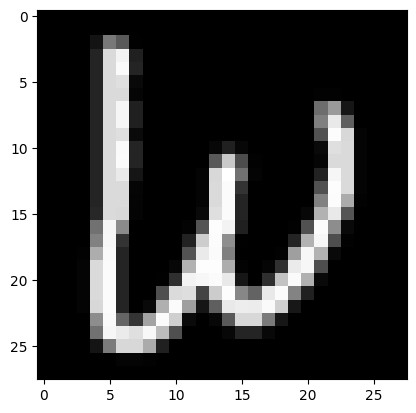

In [11]:
# Exemple de lettre contenue dans les DataSets EMNIST

label_mapping = label_mapping_emnist_byclass()
train_data = train_data_emnist_byclass()

label_trans = {}
for label_m in label_mapping:
    label_trans[label_m[0]] = chr(int(label_m[1]))

# Exemple d'une donnée EMNIST
img_nb = 150
print(label_trans[train_data[img_nb,0]])
plt.imshow(train_data[img_nb,1:].reshape(28,28).T, cmap='gray')
plt.show()

In [14]:
# Préparation des données :
def data_preparation(train_data, test_data, byclass=True):
    # 1) Séparation des labels "y" et les données de l'image "x"
    # Entrainement
    train_x = train_data[:,1:]
    train_y = train_data[:,0]
    # Test
    test_x = test_data[:,1:]
    test_y = test_data[:,0]

    # 2) Normalisation (valeur des "x" entre 0 et 1) -> Plus facile pour l'entrainement
    train_x = train_x / 255.0
    test_x = test_x / 255.0

    # 3) Reshape (Keras attend un format [batch_size, hauteur, largeur, canaux])
    train_count = train_x.shape[0]
    train_x = train_x.reshape(train_count, 28, 28, 1)

    test_count = test_x.shape[0]
    test_x = test_x.reshape(test_count, 28, 28, 1)

    # 4) Transformation des labels (Chiffre en vecteur binaire)
    if byclass:
        num_classes = 63 # (62 catégorie dans By_Class allant de 1 à 62 donc liste de longueur 63)
    else:
        num_classes = 27 # 26 catégorie dans Letters

    train_y = keras.utils.to_categorical(train_y, num_classes)
    test_y = keras.utils.to_categorical(test_y, num_classes)

    return train_x, train_y, test_x, test_y, num_classes

Nos données provenant du dataset EMNIST sont maintanant prêtes à etre utiliser dans nos différents modèle.

## 2) Entrainement et constructions des modèles
---

### 2.1) Option A (CNN Maison)

#### 2.1.1) CCN Maison 1

##### Modèle

In [15]:
# Définition des données pour le premier modèle
train_x, train_y, test_x, test_y, num_classes = data_preparation(train_data_emnist_byclass(), test_data_emnist_byclass(), True)
# Définition du premier modèle
# Modele séquentiel > Empiler les couches les unes apres les autres
model_cnn1 = Sequential()

# Creating conv layer 1
model_cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=[28, 28, 1])) # Couche convolutive 2D avec un filtre de 32
model_cnn1.add(LeakyReLU(alpha=0.1)) # Fonction d'activation non-linéaire Leaky ReLU
model_cnn1.add(MaxPooling2D((2, 2), padding='same')) # Réduction des dimension spatiales par un pooling max 2x2
model_cnn1.add(Dropout(0.25)) # Dropout de 25% pour éviter l'overfitting

# Creating conv layer 2
model_cnn1.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn1.add(Dropout(0.25))

# Adding the dense final part
model_cnn1.add(Flatten()) # Aplatissement des cartes de caractéristiques (feature maps) en un vecteur
model_cnn1.add(Dense(1024, activation='linear')) # Couche avec 1024 neurones
model_cnn1.add(LeakyReLU(alpha=0.1))
model_cnn1.add(Dropout(0.25))
model_cnn1.add(Dense(num_classes, activation='softmax')) # Couche de sortie avec autant de neurones que de classes

model_cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn1.summary()

C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 63)             │        64,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,295,679 (12.57 MB)

 Trainable params: 3,295,679 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Apprentissage du modèle et sauvegarde de celui-ci à la fin de son apprentissage et par époque
checkpoint = ModelCheckpoint('./Result/Models/model_cnn1_letters_checkpoint.keras', save_best_only=True)

model_cnn1_history = model_cnn1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, callbacks=[checkpoint])
model_cnn1.save('./Result/Models/model_cnn1_letters.keras')

Epoch 1/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.7696 - loss: 0.7465 - val_accuracy: 0.9042 - val_loss: 0.2830
Epoch 2/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9124 - loss: 0.2569 - val_accuracy: 0.9136 - val_loss: 0.2397
Epoch 3/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.9290 - loss: 0.2067 - val_accuracy: 0.9196 - val_loss: 0.2302
Epoch 4/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9329 - loss: 0.1861 - val_accuracy: 0.9194 - val_loss: 0.2311
Epoch 5/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9411 - loss: 0.1636 - val_accuracy: 0.9256 - val_loss: 0.2165
Epoch 6/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.9430 - loss: 0.1532 - val_accuracy: 0.9253 - val_loss: 0.2182
Epoch 7/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.9462 - loss: 0.1458 - val_accuracy: 0.9265 - val_loss: 0.2217
Epoch 8/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.9473 -

##### Tableau d'apprentissage

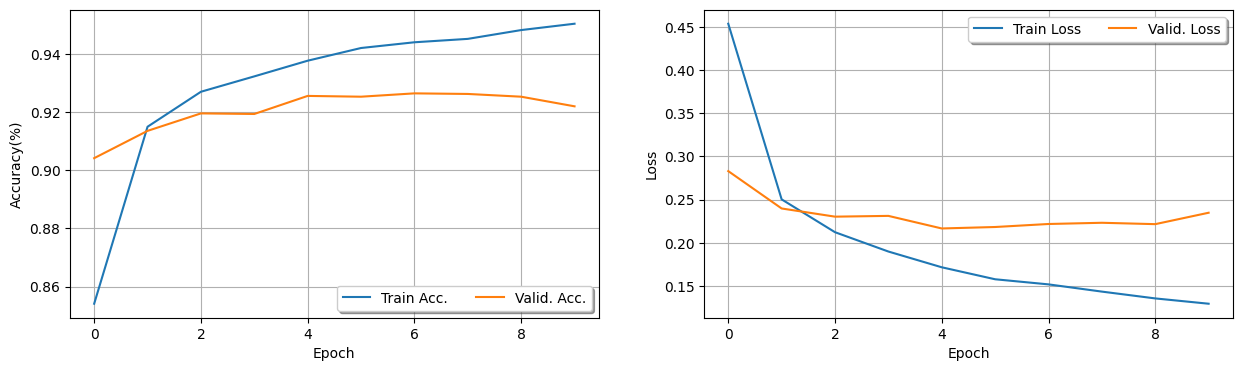

In [68]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc_cnn1 = model_cnn1_history.history['accuracy']
model_valid_acc_cnn1 = model_cnn1_history.history['val_accuracy']
model_train_loss_cnn1 = model_cnn1_history.history['loss']
model_valid_loss_cnn1 = model_cnn1_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc_cnn1, label="Train Acc.")
ax0.plot(model_valid_acc_cnn1, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss_cnn1, label="Train Loss")
ax1.plot(model_valid_loss_cnn1, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

#### 2.1.2) CCN Maison 2

##### Modèle

In [16]:
# Définition des données pour le deuxième modèle
train_x, train_y, test_x, test_y, num_classes = data_preparation(train_data_emnist_byclass(), test_data_emnist_byclass(), True)

# Définition du deuxième modèle
model_cnn2 = Sequential()

# Convolution 1
model_cnn2.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.2))

# Convolution 2
model_cnn2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.3))

# Convolution 3
model_cnn2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.4))

# Dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(256))
model_cnn2.add(LeakyReLU(alpha=0.1))
model_cnn2.add(Dropout(0.5))

model_cnn2.add(Dense(num_classes, activation='softmax'))

# Compilation
model_cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé
model_cnn2.summary()

C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 63)             │        16,191 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,927 (1.54 MB)

 Trainable params: 404,479 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
# Apprentissage du modèle et sauvegarde de celui-ci à la fin de son apprentissage et par époque
checkpoint = ModelCheckpoint('./Result/Models/model_cnn2_checkpoint.keras', save_best_only=True)

model_cnn2_history = model_cnn2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=15, callbacks=[checkpoint])
model_cnn2.save('./Result/Models/model_cnn2.keras')

Epoch 1/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 304s 39ms/step - accuracy: 0.8449 - loss: 0.4353 - val_accuracy: 0.8633 - val_loss: 0.3713
Epoch 2/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 196s 25ms/step - accuracy: 0.8443 - loss: 0.4353 - val_accuracy: 0.8608 - val_loss: 0.3692
Epoch 3/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 204s 26ms/step - accuracy: 0.8459 - loss: 0.4314 - val_accuracy: 0.8626 - val_loss: 0.3748
Epoch 4/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 207s 26ms/step - accuracy: 0.8470 - loss: 0.4307 - val_accuracy: 0.8604 - val_loss: 0.3749
Epoch 5/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 209s 27ms/step - accuracy: 0.8454 - loss: 0.4310 - val_accuracy: 0.8653 - val_loss: 0.3648
Epoch 6/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 212s 27ms/step - accuracy: 0.8473 - loss: 0.4248 - val_accuracy: 0.8656 - val_loss: 0.3669
Epoch 7/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 219s 28ms/step - accuracy: 0.8470 - loss: 0.4239 - val_accuracy: 0.8654 - val_loss: 0.3654
Epoch 8/15
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 245s 31ms/step - accuracy: 

##### Tableau d'apprentissage

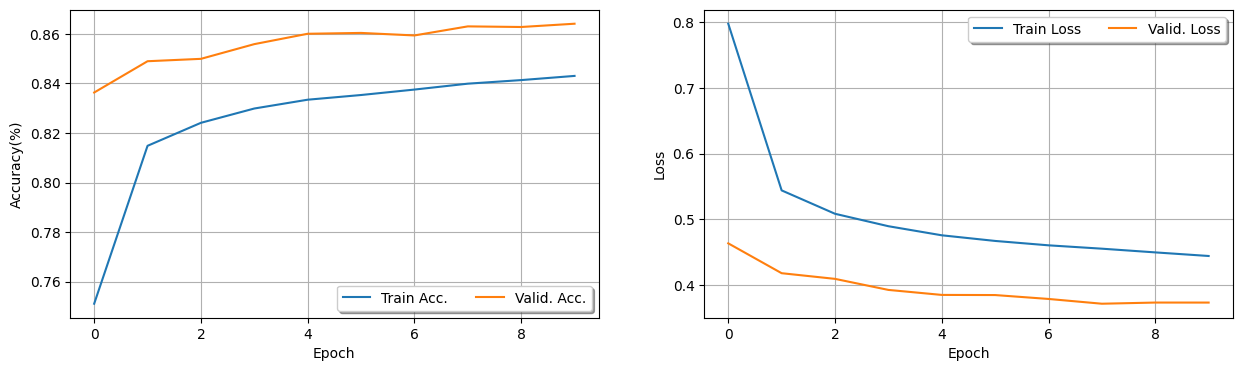

In [26]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc_cnn2 = model_cnn2_history.history['accuracy']
model_valid_acc_cnn2 = model_cnn2_history.history['val_accuracy']
model_train_loss_cnn2 = model_cnn2_history.history['loss']
model_valid_loss_cnn2 = model_cnn2_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc_cnn2, label="Train Acc.")
ax0.plot(model_valid_acc_cnn2, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss_cnn2, label="Train Loss")
ax1.plot(model_valid_loss_cnn2, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

### 2.2) Option B (Transfert Learning)

#### 2.2.1) Transfer Learning 1 (MobileNetV2)

##### Modèle Feature Extraction

In [20]:
# Fonction de preprocessing standard (inchangée)
def preprocess(x, y):
    x = tf.image.grayscale_to_rgb(x)  # Convert grayscale to RGB (28x28x1 -> 28x28x3)
    x = tf.image.resize(x, (160, 160))  # Resize to 160x160 for faster training
    x = tf.cast(x, tf.float32) / 255.0  # Normalize to [0, 1]
    return x, y

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontal et vertical
    layers.RandomRotation(0.2),  # Rotation aléatoire jusqu'à 20%
    layers.RandomZoom(0.2),  # Zoom aléatoire jusqu'à 20%
], name="data_augmentation")

# Préparation du jeu d'entraînement avec augmentation
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Préparation du jeu de test → PAS d'augmentation
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 pre-trained on ImageNet, excluding the top (classification) layers
base_model_tle_tf = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))

# Freeze the base model to perform feature extraction
base_model_tle_tf.trainable = False

# Build the model with a custom classifier on top of MobileNetV2
model_tle_tf = models.Sequential([
    base_model_tle_tf,  # MobileNetV2 as feature extractor
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce the feature map size
    layers.Dense(128, activation='relu'),  # Dense layer for classification
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(63, activation='softmax')  # Output layer with 63 classes (EMNIST Letters)
])

# Compile the model with a smaller learning rate for stability
model_tle_tf.compile(optimizer=Adam(learning_rate=0.0005),
                     loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                     metrics=['accuracy'])

print("Model compiled...")

# Early stopping to prevent overfitting and save time if the model stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Model summary
model_tle_tf.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model compiled...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,079 (9.27 MB)

 Trainable params: 172,095 (672.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
print("Training...")
# Train the model using feature extraction (base model frozen)
history = model_tle_tf.fit(train_ds, validation_data=test_ds, epochs=4, callbacks=[early_stopping], verbose=1)
print("Training finish")

Training...
Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 473s 301ms/step - accuracy: 0.0458 - loss: 3.8607 - val_accuracy: 0.0682 - val_loss: 3.7261
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 476s 304ms/step - accuracy: 0.0508 - loss: 3.7388 - val_accuracy: 0.0579 - val_loss: 3.6840
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 489s 313ms/step - accuracy: 0.0503 - loss: 3.7316 - val_accuracy: 0.0579 - val_loss: 3.6787
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 459s 293ms/step - accuracy: 0.0514 - loss: 3.7258 - val_accuracy: 0.0579 - val_loss: 3.6808
Training finish


##### Tableau d'apprentissage (Feature Extraction)

##### Modèle Fine-tuning

In [8]:
base_model_tle_tf.trainable = True

# Definie la partie a dégeler
fine_tune_at = len(base_model_tle_tf.layers) - 15

# Re-compile avec learning rate plus faible
model_tle_tf.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_tle_tf.summary()

history_fine_tuning = model_tle_tf.fit(train_ds, validation_data=test_ds, epochs=1, callbacks=[early_stopping], verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,079 (9.27 MB)

 Trainable params: 2,395,967 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1631s 1s/step - accuracy: 0.0757 - loss: 4.0729 - val_accuracy: 0.0541 - val_loss: 3.9930
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1607s 1s/step - accuracy: 0.2985 - loss: 2.9165 - val_accuracy: 0.0480 - val_loss: 4.0876
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1605s 1s/step - accuracy: 0.4152 - loss: 2.3924 - val_accuracy: 0.1334 - val_loss: 3.6801
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1602s 1s/step - accuracy: 0.4902 - loss: 2.0622 - val_accuracy: 0.5994 - val_loss: 1.5492


Modification du fine tuning :

1. Nous dégelons tous les layers apres le 100, les premiers layers ont généralement une vision génériques (bord, textures, etc)
et donc n'ont pas besoin d'être modifier pour améliorer les prédictions. Ce qui est l'inverses des derniers layers
qui sont ceux qui doivent être les plus adaptés pour notre dataset
2. Learning rate est aussi plus faible pour éviter de détruire les poids pré-entrainer
mais simplement les affiners
3. Nombre d'époch faibles pour éviter l'overfiting

##### Tableau d'apprentissage (Fine-tuning)

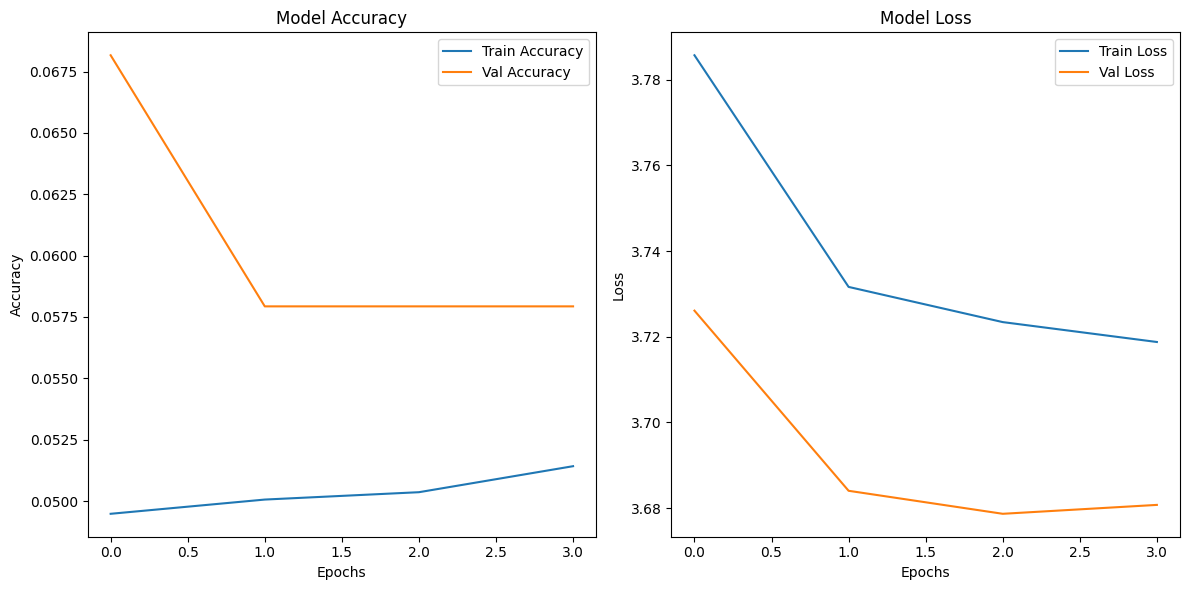

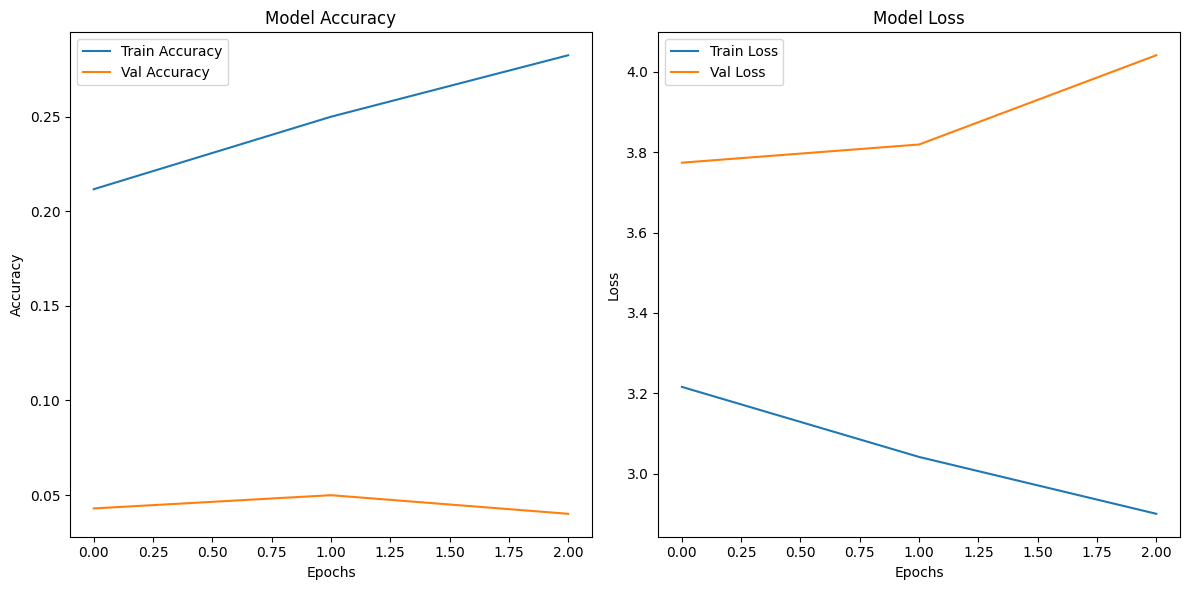

In [28]:
# Visualize the training history (accuracy and loss)
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the results after feature extraction
plot_training_history(history)

# If fine-tuning was performed, visualize it as well
plot_training_history(history_fine_tuning)


#### 2.2.2) Transfer Learning 2 (ResNet50V2)

##### Modèle Feature Extraction

In [ ]:
# Load EMNIST Letters dataset
def load_emnist_letters(root="./data", train=True):
    return torchvision.datasets.EMNIST(
        root=root,
        split="letters",
        train=train,
        download=False,
        transform=torchvision.transforms.ToTensor()
    )

In [ ]:
# Convert EMNIST to numpy arrays
def emnist_to_numpy(dataset, max_samples=None):
    images = []
    labels = []
    for i, (img, label) in enumerate(dataset):
        if max_samples and i >= max_samples:
            break
        img_np = img.numpy().squeeze()
        images.append(img_np)
        labels.append(label - 1)  # EMNIST Letters labels start at 1
    return np.array(images), np.array(labels)

In [ ]:
# Build the transfer learning model
def build_transfer_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model for feature extraction

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
def build_transfer_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(26, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Batch the data
def create_emnist_tf_dataset(images, labels, batch_size=32, shuffle=True):
    def preprocess(x, y):
        x = tf.stack([x, x, x], axis=-1)
        x = tf.image.resize(x, [224, 224])
        return x, y
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_dataset = load_emnist_letters(train=True)
test_dataset = load_emnist_letters(train=False)
train_images, train_labels = emnist_to_numpy(train_dataset, max_samples=10000)
test_images, test_labels = emnist_to_numpy(test_dataset, max_samples=2000)
train_ds = create_emnist_tf_dataset(train_images, train_labels)
test_ds = create_emnist_tf_dataset(test_images, test_labels, shuffle=False)

# Train the model
model_CNN1 = build_transfer_model()
history = model_CNN1.fit(train_ds, validation_data=test_ds, epochs=5)

##### Tableau d'apprentissage (Feature Extraction)

In [ ]:
# 1. Unfreeze top layers of the base model
base_tle_tf_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_tle_tf_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_tle_tf_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

In [ ]:
# 0. Unfreeze top layers of the base model
base_tle_tf_model = model_CNN1.layers[-1]  # Access MobileNetV2 inside the Sequential
base_tle_tf_model.trainable = True

# 1. Freeze most layers, keep top N trainable
for layer in base_tle_tf_model.layers[:-31]:
    layer.trainable = False

# 2. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=0e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 3. Continue training
fine_tune_epochs = 2
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

##### Modèle Fine-tuning

In [ ]:
# 1. Unfreeze top layers of the base model
base_tle_tf_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_tle_tf_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_tle_tf_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

##### Tableau d'apprentissage (Fine-tuning)

In [ ]:
# TO DO

## 3) Évaluation Comparative et Analyse Critique des modèles
---
Explication et résumer des résultat avec les tableaux etc
Meilleur modele dans quel cas et pourquoi (temps, MSE, accuracy, etc)

## 4) Application réel du projet
---

### 4.1) Vidéo

In [60]:
# Extraction de la lettre / forme à partir d'une vidéo via la reconnaissance image au niveau de la main
def traitement_video(video_path, final_letter_frame, frame_interval=2):
    # === 1. Extraction des frames ===
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erreur : impossible d'ouvrir la vidéo '{video_path}'")
        exit()

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Vidéo chargée : {total_frames} frames à {fps:.2f} fps")

    # === 2. Initialisation ===
    trace_points = []
    frame_count = 0
    saved_count = 0
    img_shape = None
    detector = HandDetector(staticMode=True, maxHands=1, detectionCon=0.7)

    # === 3. Parcours des frames en mémoire ===
    while True:
        success, frame = cap.read()
        if not success:
            break

        if frame_count % frame_interval == 0:
            image = frame.copy()
            hands, img = detector.findHands(image)

            if hands:
                hand = hands[0]
                lm_list = hand['lmList']
                if len(lm_list) >= 9:
                    x, y = lm_list[8][0], lm_list[8][1]
                    trace_points.append((x, y))

            if img_shape is None:
                img_shape = img.shape

            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"{saved_count} images traitées")

    # === 4. Génération de l'image composite ===
    height, width, _ = img_shape
    result = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(1, len(trace_points)):
        cv2.line(result, trace_points[i - 1], trace_points[i], (0, 0, 255), thickness=6)

    # === 5. Rotation de 90° vers la droite ===
    rotated = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

    # === 6. Effet miroir (symétrie horizontale) ===
    mirrored = cv2.flip(rotated, 1)

    # === 7. Sauvegarde de l'image finale ===
    cv2.imwrite(final_letter_frame, mirrored)
    print(f"Image finale enregistrée sous '{final_letter_frame}' ({total_frames} frames à {fps:.2f} fps ,Images traitées = {saved_count})")

# Extraction des lettres dans toutes les vidéos présent dans le dossier vidéo
video_folder = './Result/videos/Lettres/'
path_letter_frame = './Result/Hand_Detected_Images/'
os.makedirs(path_letter_frame, exist_ok=True)
compteur = 0

for name_folder in sorted(os.listdir(video_folder)):
    if name_folder.lower().endswith('.mp4'):
        video_path = os.path.join(video_folder, name_folder)
        lettre_video = os.path.splitext(name_folder)[0]
        path_letter_frame_good = f'{path_letter_frame}{lettre_video}.png'
        traitement_video(video_path, path_letter_frame_good, 2)
        compteur += 1

print(f"Traitement de {compteur} videos terminé")


Vidéo chargée : 521 frames à 60.00 fps


KeyboardInterrupt: 

In [28]:
# Affichage des images de lettres extraites de vidéos
# === Paramètres ===
image_dir = './Result/Hand_Detected_Images'

# === Récupération des images ===
image_files = sorted([
    f for f in os.listdir(image_dir)
    if f.lower().endswith('.png')
])

# === Création de la figure ===
fig, axes = plt.subplots(4, 7, figsize=(100, 80))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_files):
        image_path = os.path.join(image_dir, image_files[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

plt.tight_layout()
plt.show()

### 4.2) Traitements d'image
Standardisation des lettres dessinées, extraites des vidéos ci-dessus afin d'avoir le format 28x28 pixels comme le dataset EMNIST sur lequel notre modèle c'est entrainé.

In [1]:
# Step 1: Extract red from image
def extract_red_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    return cv2.bitwise_or(mask1, mask2)

# Step 2: Basic cleaning (open/close)
def clean_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Step 3: Keep relevant parts
def filter_components(mask, min_area=20):
    labeled = label(mask)
    cleaned = np.zeros_like(mask)
    for region in regionprops(labeled):
        if region.area >= min_area:
            for y, x in region.coords:
                cleaned[y, x] = 255
    return cleaned

# Step 4: Skeletonize
def get_skeleton(mask):
    return (skeletonize(mask > 0) * 255).astype(np.uint8)

# Step 5 : Bold the ligne
def thicken_mask(mask, size=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    return cv2.dilate(mask, kernel, iterations=1)

# Step 6: Resize and center
def center_crop_and_scale(mask, output_size=28, margin=20):
    # Trouver les contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros((output_size, output_size), dtype=np.uint8)

    # Bounding box autour du plus grand contour
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

    # Calcul carré englobant avec marge
    max_dim = max(w, h) + margin
    center_x, center_y = x + w // 2, y + h // 2
    half = max_dim // 2

    # Bords du carré
    top = max(center_y - half, 0)
    bottom = min(center_y + half, mask.shape[0])
    left = max(center_x - half, 0)
    right = min(center_x + half, mask.shape[1])

    # Crop carré
    cropped = mask[top:bottom, left:right]

    # Redimensionnement à 28x28
    resized = cv2.resize(cropped, (output_size, output_size), interpolation=cv2.INTER_AREA)

    return resized

# Main function
def process_image(path, save_step=False):
    list_step = []
    img = cv2.imread(path)

    mask = extract_red_mask(img)

    cleaned = clean_mask(mask)

    filtered = filter_components(cleaned)

    skeleton = get_skeleton(filtered)

    thickened = thicken_mask(skeleton, size=100)

    final = center_crop_and_scale(thickened, margin=300, output_size=28)

    if save_step:
        list_step.extend([img, mask, cleaned, filtered, skeleton, thickened, final])
        # list_step.extend([img, mask, cleaned, filtered, thickened, final])
        return list_step
    return final

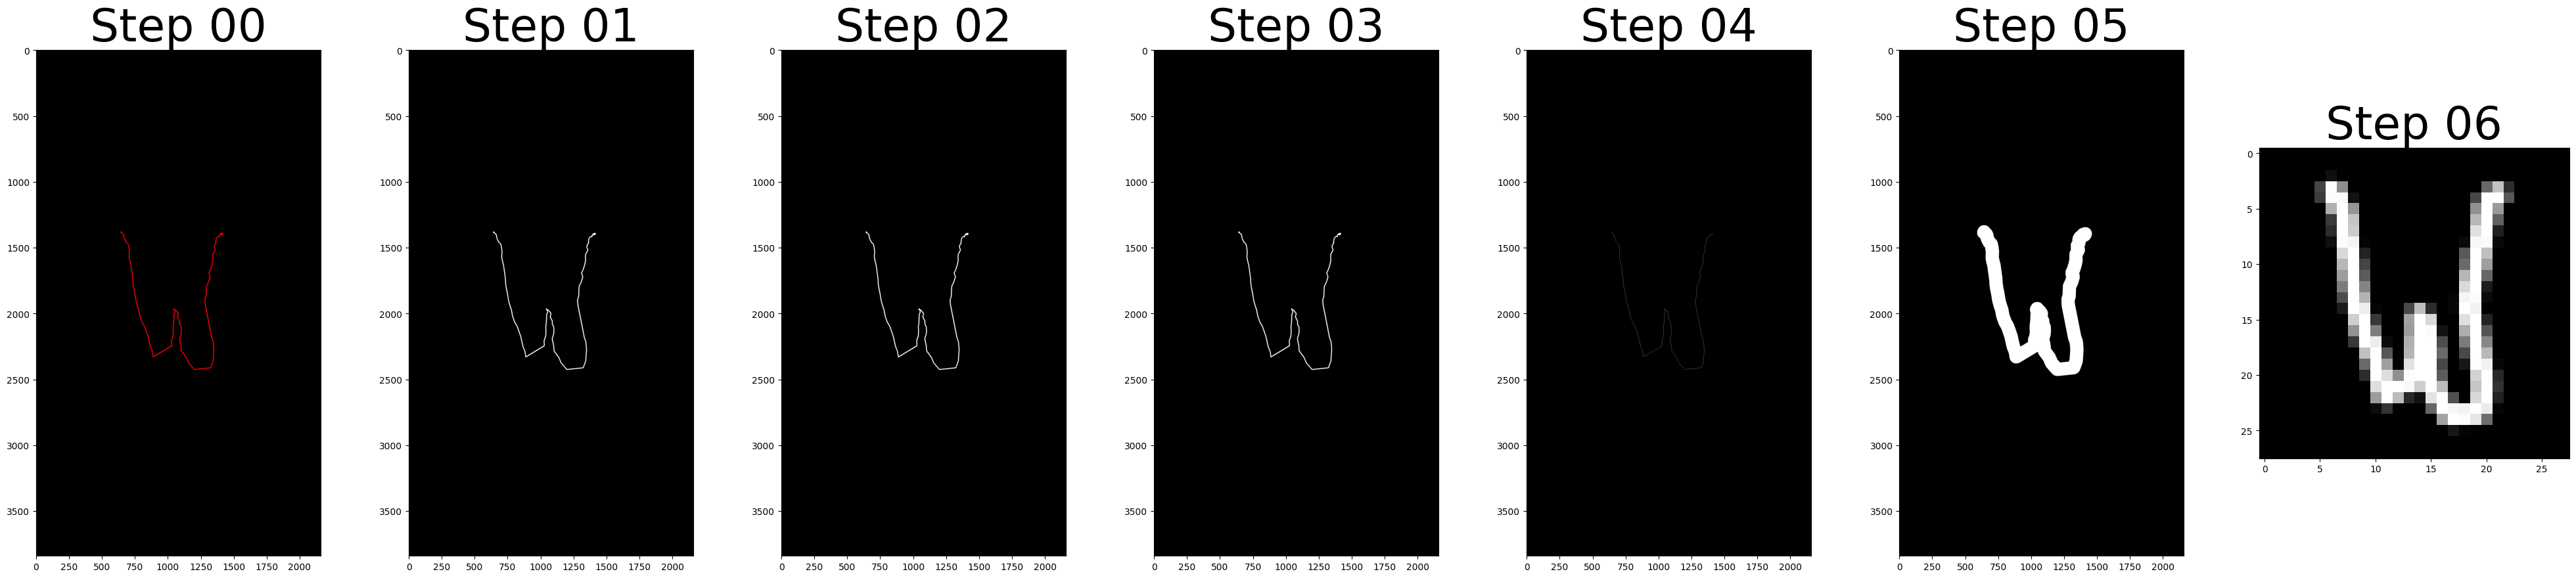

In [5]:
# Différentes étapes du traitement d'image
# === Paramètres ===
image_dir = process_image("./Result/Hand_Detected_Images/W.png", save_step=True)

# === Création de la figure ===
fig, axes = plt.subplots(1, 7, figsize=(50, 10))
axes = axes.flatten()
i = 0

for i, ax in enumerate(axes):
    img = image_dir[i]

    # Si l'image est en niveaux de gris
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
    ax.set_title(f"Step {i:02d}", fontsize=50)

plt.show()

Pour pouvoir donner l'image traité à notre modèle entrainé nous devons la préparer au format attendu par le modele.

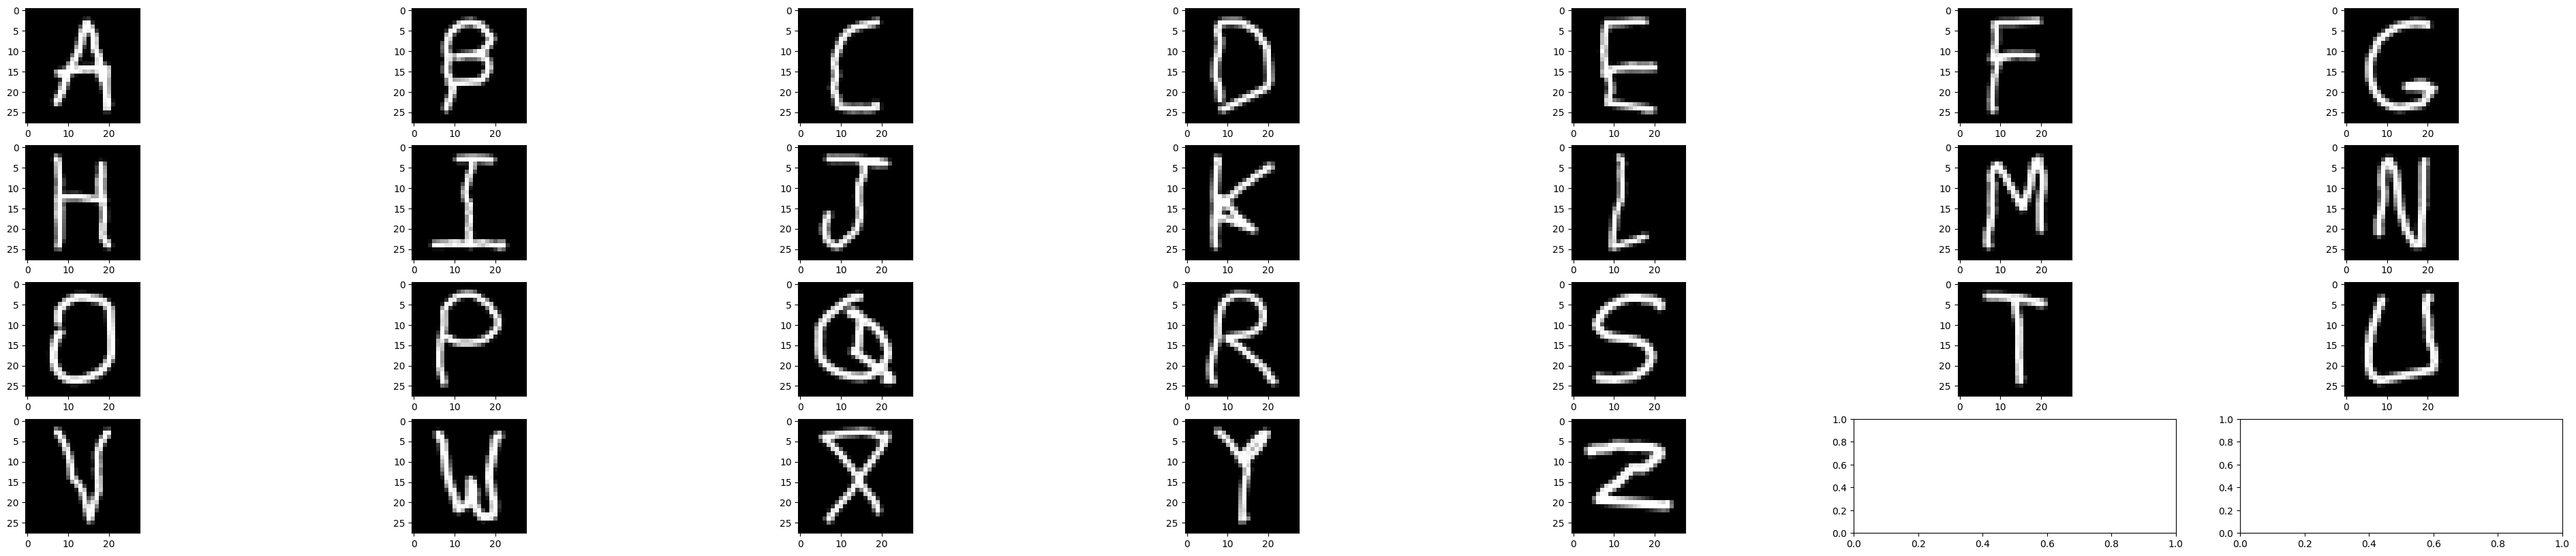

In [4]:
# Creation du dataset comprenant les images traité extraites des vidéos
image_folder = './Result/Hand_Detected_Images/'
data_samples = []
fig, axes = plt.subplots(4, 7, figsize=(50, 10))
axes = axes.flatten()
i = 0

for name_folder in sorted(os.listdir(image_folder)):
    if name_folder.lower().endswith('.png'):
        letter_label = os.path.splitext(name_folder)[0]
        image_path = f'{image_folder}{letter_label}.png'

        # Traitement image 28x28 et affichage des images traité
        processed_img  = process_image(image_path)
        ax = axes[i]
        ax.imshow(processed_img,cmap='gray')
        i += 1

        # Stockage des lettre
        data_samples.append((letter_label, processed_img))

# Affichage des lettres après traitement
plt.show()

### 4.3) Application du Meilleur Modèle entrainé sur la reconnaissance d'image


- Expected "A"; Predicted: "E" (94.57%) | 2nd: "K" (2.89%)


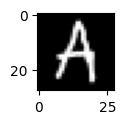

- Expected "B"; Predicted: "A" (54.61%) | 2nd: "O" (29.12%)


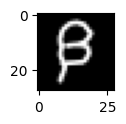

- Expected "C"; Predicted: "M" (99.89%) | 2nd: "N" (0.11%)


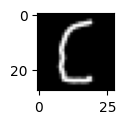

- Expected "D"; Predicted: "O" (72.06%) | 2nd: "A" (27.34%)


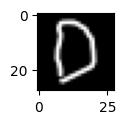

- Expected "E"; Predicted: "M" (100.00%) | 2nd: "N" (0.00%)


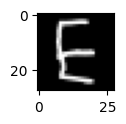

- Expected "F"; Predicted: "T" (59.26%) | 2nd: "M" (18.56%)


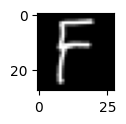

- Expected "G"; Predicted: "N" (99.90%) | 2nd: "A" (0.06%)


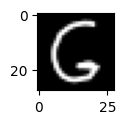

- Expected "H"; Predicted: "I" (100.00%) | 2nd: "J" (0.00%)


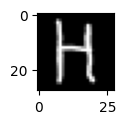

- Expected "I"; Predicted: "M" (87.56%) | 2nd: "H" (12.44%)


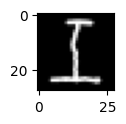

- Expected "J"; Predicted: "P" (99.00%) | 2nd: "W" (1.00%)


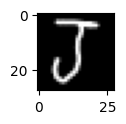

- Expected "K"; Predicted: "T" (85.46%) | 2nd: "X" (11.61%)


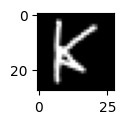

- Expected "L"; Predicted: "T" (97.17%) | 2nd: "M" (1.05%)


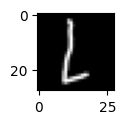

- Expected "M"; Predicted: "E" (98.71%) | 2nd: "I" (0.80%)


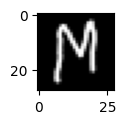

- Expected "N"; Predicted: "S" (98.61%) | 2nd: "E" (1.38%)


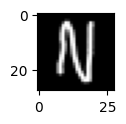

- Expected "O"; Predicted: "O" (99.85%) | 2nd: "Q" (0.13%)


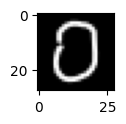

- Expected "P"; Predicted: "J" (96.40%) | 2nd: "O" (3.20%)


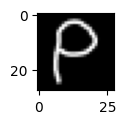

- Expected "Q"; Predicted: "Q" (100.00%) | 2nd: "A" (0.00%)


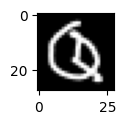

- Expected "R"; Predicted: "Q" (95.74%) | 2nd: "G" (2.77%)


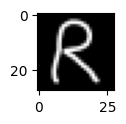

- Expected "S"; Predicted: "N" (100.00%) | 2nd: "W" (0.00%)


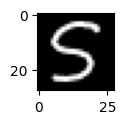

- Expected "T"; Predicted: "F" (60.51%) | 2nd: "M" (14.39%)


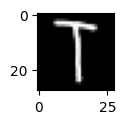

- Expected "U"; Predicted: "J" (99.50%) | 2nd: "D" (0.38%)


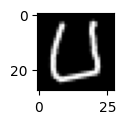

- Expected "V"; Predicted: "S" (97.22%) | 2nd: "Z" (2.77%)


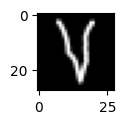

- Expected "W"; Predicted: "Z" (99.49%) | 2nd: "B" (0.38%)


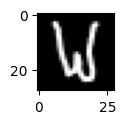

- Expected "X"; Predicted: "X" (99.98%) | 2nd: "N" (0.01%)


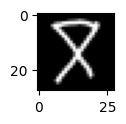

- Expected "Y"; Predicted: "Z" (55.15%) | 2nd: "X" (15.71%)


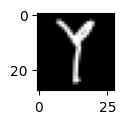

- Expected "Z"; Predicted: "N" (60.43%) | 2nd: "U" (26.31%)


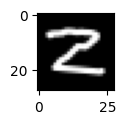


Accuracy: 3/26 (11.54%)


In [6]:
correct = []

model_for_predict = load_model("./Result/Models/model_cnn1_letters.keras")
label_mapping = label_mapping_emnist_letters()
# !!! Attention a bien changer pour que le type de DataSet d'entrainement sois le même que le label_mapping !!!

label_trans = {}
for label_m in label_mapping:
    label_trans[label_m[0]] = chr(int(label_m[1]))

for true_label, img in data_samples:
    x = img.reshape(1, 28, 28, 1) / 255.0
    res = model_for_predict.predict(x, verbose=0).reshape(-1)
    res_ind = np.flip(np.argsort(res))

    pred_char_1 = label_trans[res_ind[0]]
    pred_char_2 = label_trans[res_ind[1]]

    if true_label == pred_char_1:
        correct.append(label)

    print(f'- Expected "{true_label}"; Predicted: "{pred_char_1}" ({res[res_ind[0]]*100:.2f}%) | 2nd: "{pred_char_2}" ({res[res_ind[1]]*100:.2f}%)')
    plt.figure(figsize=(1,1))
    plt.imshow(img, cmap='gray')
    plt.show()

print(f'\nAccuracy: {len(correct)}/{len(data_samples)} ({100 * len(correct)/len(data_samples):.2f}%)')


## 5) Conclusions et Décisions
---
TO DO